# Is my German or American Twitter Network "Happier"?
#### Using sentiment analysis, compare the tweets of German and American Twitter Networks to see which group is more positive (or "happier").

In [152]:
import pandas as pd
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import string
import warnings
warnings.filterwarnings("ignore")
from textblob import TextBlob
from textblob_de import TextBlobDE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import df with tweets from previous notebook:
tweets = pd.read_csv('tweets_to_preprocess_NLP.csv')

In [3]:
tweets.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
tweets.drop('Geocode', axis=1, inplace=True)

In [5]:
tweets.head()

,TweetText,Handle,ID,CreatedAt,Follower,Location,UserDescription,Location_code,Friend,Country
0,RT @z_edian: Unser @snv_berlin Expert:innenwor...,christinacrupp,1359905846659059713,2021-02-11 16:43:14,Christina Rupp,"Bonn, Deutschland",Project Assistant International Cybersecurity ...,2.0,NaN,Germany
1,RT @rachel_groves: Daily goals: Wake up early....,joscchh,1359905846659059713,2021-02-11 16:43:14,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",2.0,NaN,Germany
2,RT @michael_adler_: Fing gut an! Bonn braucht ...,joscchh,1359101568390414337,2021-02-09 11:27:19,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",2.0,NaN,Germany
3,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,1359019191358156802,2021-02-09 05:59:59,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",2.0,NaN,Germany
4,"Gestern haben @Lichtemomente, @askans, @michae...",joscchh,1359015354828210176,2021-02-09 05:44:44,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",2.0,NaN,Germany


### Before pre-processing the data for NLP, separate tweet by language:

In [6]:
from langdetect import detect

In [7]:
detect(tweets['TweetText'][0])
# it detects the first tweet as being German

'de'

In [8]:
detect(tweets['TweetText'][1])
# and it detects the second tweet as being English. 

'en'

In [10]:
for index, row in tweets['TweetText'].iteritems():
    try:
        lang = detect(row)
        
    except:
        lang = 0
        
    tweets.loc[index, 'Language'] = lang

In [12]:
tweets['Language'].value_counts()

en    4794
de    3068
0       78
es      66
it      48
nl      43
fr      33
id      31
no      29
af      25
da      24
et      19
ro      18
cy      17
tl      17
fi      17
pl      13
so      12
ca       9
sv       8
pt       7
sw       7
ja       6
tr       6
sq       5
lt       4
hu       3
lv       3
sk       3
vi       3
sl       3
ru       2
hr       2
th       1
cs       1
Name: Language, dtype: int64

In [14]:
tweets.drop(['Friend', 'Location_code'], axis=1, inplace=True)

In [15]:
tweets.head()

,TweetText,Handle,ID,CreatedAt,Follower,Location,UserDescription,Country,Language
0,RT @z_edian: Unser @snv_berlin Expert:innenwor...,christinacrupp,1359905846659059713,2021-02-11 16:43:14,Christina Rupp,"Bonn, Deutschland",Project Assistant International Cybersecurity ...,Germany,de
1,RT @rachel_groves: Daily goals: Wake up early....,joscchh,1359905846659059713,2021-02-11 16:43:14,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en
2,RT @michael_adler_: Fing gut an! Bonn braucht ...,joscchh,1359101568390414337,2021-02-09 11:27:19,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de
3,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,1359019191358156802,2021-02-09 05:59:59,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en
4,"Gestern haben @Lichtemomente, @askans, @michae...",joscchh,1359015354828210176,2021-02-09 05:44:44,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de


### Basic Text Cleanup:

Remove RT, Punctuation, etc.

In [16]:
# add new column in df to clean up the texts
tweets['text'] = tweets['TweetText']

In [17]:
tweets['text']

0       RT @z_edian: Unser @snv_berlin Expert:innenwor...
1       RT @rachel_groves: Daily goals: Wake up early....
2       RT @michael_adler_: Fing gut an! Bonn braucht ...
3            RT @EurAsiaBridgeEU: good topic - well done.
4       Gestern haben @Lichtemomente, @askans, @michae...
                              ...                        
8420    RT @jana_hensel: Friedrich Merz hat eine Frau ...
8421    Ich hätte nie gedacht, dass ich das mal sage. ...
8422    RT @Mareicares: Dass da echt eine Frau ihren J...
8423    RT @Nilzenburger: Sich so einen perfiden Begri...
8424    Hat gerade ein Foto gepostet @ Berlin, Germany...
Name: text, Length: 8425, dtype: object

In [18]:
list_tweets = list(tweets['text'])

In [19]:
test= tweets.iloc[0][0]

In [20]:
test

'RT @z_edian: Unser @snv_berlin Expert:innenworkshop zur "staatlichen Beantwortung von böswilligen Cyberaktivitäten" geht langsam zuende.\n\nD…'

In [21]:
remove_rt = lambda x: re.sub('RT @\w+: ', "", x)

In [22]:
lab = lambda x: re.sub('[^äöüÄÖÜA-Za-z ]+','', x)

In [23]:
test1 = remove_rt(test)
test1

'Unser @snv_berlin Expert:innenworkshop zur "staatlichen Beantwortung von böswilligen Cyberaktivitäten" geht langsam zuende.\n\nD…'

In [24]:
test2 = lab(test1)

In [25]:
test2.lower()

'unser snvberlin expertinnenworkshop zur staatlichen beantwortung von böswilligen cyberaktivitäten geht langsam zuended'

In [26]:
# Make this into a function:

def clean_up(x):
    """ Clean up the text before NLP. 
    Remove Punctuation, remove retweet and @.
    Keep German characters as vowels."""
    
    remove_rt = lambda x: re.sub('RT @\w+: ', "", x)
    lab = lambda x: re.sub('[^äöüÄÖÜA-Za-z ]+','', x)
    tw_1 = remove_rt(x)
    tw_2 = lab(tw_1)
    tw_3 =  tw_2.lower()
    
    return tw_3
    

In [27]:
# Test the function with 1 tweet before applying to the column
clean_up('RT @z_edian: Unser @snv_berlin Expert:innenworkshop zur "staatlichen Beantwortung von böswilligen Cyberaktivitäten" geht langsam zuende.\n\nD…')

'unser snvberlin expertinnenworkshop zur staatlichen beantwortung von böswilligen cyberaktivitäten geht langsam zuended'

In [28]:
tweets['text'] = tweets['text'].apply(clean_up)

In [29]:
tweets.head()

,TweetText,Handle,ID,CreatedAt,Follower,Location,UserDescription,Country,Language,text
0,RT @z_edian: Unser @snv_berlin Expert:innenwor...,christinacrupp,1359905846659059713,2021-02-11 16:43:14,Christina Rupp,"Bonn, Deutschland",Project Assistant International Cybersecurity ...,Germany,de,unser snvberlin expertinnenworkshop zur staatl...
1,RT @rachel_groves: Daily goals: Wake up early....,joscchh,1359905846659059713,2021-02-11 16:43:14,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,daily goals wake up early drink coffee work ha...
2,RT @michael_adler_: Fing gut an! Bonn braucht ...,joscchh,1359101568390414337,2021-02-09 11:27:19,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,fing gut an bonn braucht einen mindshift von d...
3,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,1359019191358156802,2021-02-09 05:59:59,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,good topic well done
4,"Gestern haben @Lichtemomente, @askans, @michae...",joscchh,1359015354828210176,2021-02-09 05:44:44,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,gestern haben lichtemomente askans michaeladle...


### Tokenization:

In [41]:
def tokenize(x):
    """Tokenize the tweets."""
    
    from nltk.tokenize import word_tokenize
    tokenized_x = word_tokenize(x)
    return tokenized_x

In [42]:
tokenize(tweets['text'][0])

['unser',
 'snvberlin',
 'expertinnenworkshop',
 'zur',
 'staatlichen',
 'beantwortung',
 'von',
 'böswilligen',
 'cyberaktivitäten',
 'geht',
 'langsam',
 'zuended']

In [43]:
tweets['tokenized_tw'] = tweets['text'].apply(tokenize)

In [44]:
tweets.head()

,TweetText,Handle,ID,CreatedAt,Follower,Location,UserDescription,Country,Language,text,tokenized_tw
0,RT @z_edian: Unser @snv_berlin Expert:innenwor...,christinacrupp,1359905846659059713,2021-02-11 16:43:14,Christina Rupp,"Bonn, Deutschland",Project Assistant International Cybersecurity ...,Germany,de,unser snvberlin expertinnenworkshop zur staatl...,"[unser, snvberlin, expertinnenworkshop, zur, s..."
1,RT @rachel_groves: Daily goals: Wake up early....,joscchh,1359905846659059713,2021-02-11 16:43:14,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,daily goals wake up early drink coffee work ha...,"[daily, goals, wake, up, early, drink, coffee,..."
2,RT @michael_adler_: Fing gut an! Bonn braucht ...,joscchh,1359101568390414337,2021-02-09 11:27:19,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,fing gut an bonn braucht einen mindshift von d...,"[fing, gut, an, bonn, braucht, einen, mindshif..."
3,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,1359019191358156802,2021-02-09 05:59:59,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,good topic well done,"[good, topic, well, done]"
4,"Gestern haben @Lichtemomente, @askans, @michae...",joscchh,1359015354828210176,2021-02-09 05:44:44,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,gestern haben lichtemomente askans michaeladle...,"[gestern, haben, lichtemomente, askans, michae..."


### Subset in German and English dataframes for the stemming/lemmatizing/vectorizing/analysis:

In [47]:
tweets_en = tweets[tweets['Language']=='en']
tweets_en.shape

(4794, 11)

In [48]:
tweets_de = tweets[tweets['Language']=='de']
tweets_de.shape

(3068, 11)

In [49]:
# So there are now a couple hundred tweets dropped from my analysis since the language was either not detected, or not detected as en/de.

### Stemming and Lemmatization:

In [76]:
def stem_lemmatize_en(l):
    """This function performs both stemming and lemmatization on our english tweets."""
    
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    l = [lemmatizer.lemmatize(item) for item in l]
    from nltk.stem import SnowballStemmer
    stemmer = SnowballStemmer("english")
    l = [stemmer.stem(item) for item in l]
    
    return l 

In [77]:
tweets_en['stem_lemm_tw'] = tweets_en['tokenized_tw'].apply(stem_lemmatize_en)

In [78]:
tweets_en.head()
# Does it actually look like the texts have changed enough from stemming and lemmatization?? 

,TweetText,Handle,ID,CreatedAt,Follower,Location,UserDescription,Country,Language,text,tokenized_tw,stem_lemm_tw,remove_stopwords_tw
1,RT @rachel_groves: Daily goals: Wake up early....,joscchh,1359905846659059713,2021-02-11 16:43:14,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,daily goals wake up early drink coffee work ha...,"[daily, goals, wake, up, early, drink, coffee,...","[daili, goal, wake, up, earli, drink, coffe, w...","[daili, goal, wake, earli, drink, coffe, work,..."
3,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,1359019191358156802,2021-02-09 05:59:59,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,good topic well done,"[good, topic, well, done]","[good, topic, well, done]","[good, topic, well, done]"
8,@jpbrice Life is always precious - every singl...,joscchh,1358756115320885248,2021-02-08 12:34:37,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,jpbrice life is always precious every single ...,"[jpbrice, life, is, always, precious, every, s...","[jpbrice, life, is, alway, precious, everi, si...","[jpbrice, life, alway, precious, everi, singl,..."
11,@PeterShepherd8 @MYorke27 @ZEReadyOregon Great...,joscchh,1356880098310422528,2021-02-03 08:19:59,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,petershepherd myorke zereadyoregon great we h...,"[petershepherd, myorke, zereadyoregon, great, ...","[petershepherd, myork, zereadyoregon, great, w...","[petershepherd, myork, zereadyoregon, great, l..."
12,RT @jpbrice: “You never know how strong you ar...,joscchh,1355578851544412168,2021-01-30 18:09:18,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,you never know how strong you are until being ...,"[you, never, know, how, strong, you, are, unti...","[you, never, know, how, strong, you, are, unti...","[never, know, strong, strong, onli, choic, quo..."


In [79]:
def stem_lemmatize_de(l):
    """This function performs both stemming and lemmatization on our german tweets."""
    
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    l = [lemmatizer.lemmatize(item) for item in l]
    from nltk.stem import SnowballStemmer
    stemmer = SnowballStemmer("german")
    l = [stemmer.stem(item) for item in l]
    
    return l 

In [80]:
tweets_de['stem_lemm_tw'] = tweets_de['tokenized_tw'].apply(stem_lemmatize_de)
tweets_de.head()

,TweetText,Handle,ID,CreatedAt,Follower,Location,UserDescription,Country,Language,text,tokenized_tw,stem_lemm_tw
0,RT @z_edian: Unser @snv_berlin Expert:innenwor...,christinacrupp,1359905846659059713,2021-02-11 16:43:14,Christina Rupp,"Bonn, Deutschland",Project Assistant International Cybersecurity ...,Germany,de,unser snvberlin expertinnenworkshop zur staatl...,"[unser, snvberlin, expertinnenworkshop, zur, s...","[uns, snvberlin, expertinnenworkshop, zur, sta..."
2,RT @michael_adler_: Fing gut an! Bonn braucht ...,joscchh,1359101568390414337,2021-02-09 11:27:19,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,fing gut an bonn braucht einen mindshift von d...,"[fing, gut, an, bonn, braucht, einen, mindshif...","[fing, gut, an, bonn, braucht, ein, mindshift,..."
4,"Gestern haben @Lichtemomente, @askans, @michae...",joscchh,1359015354828210176,2021-02-09 05:44:44,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,gestern haben lichtemomente askans michaeladle...,"[gestern, haben, lichtemomente, askans, michae...","[gest, hab, lichtemoment, askan, michaeladl, b..."
5,@VolkerGoebbels Macht Sinn 😏,joscchh,1358806042960932869,2021-02-08 15:53:00,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,volkergoebbels macht sinn,"[volkergoebbels, macht, sinn]","[volkergoebbel, macht, sinn]"
6,@jbrunotte Was waren denn deine Beweggründe da...,joscchh,1358758503419162624,2021-02-08 12:44:06,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,jbrunotte was waren denn deine beweggründe daf...,"[jbrunotte, was, waren, denn, deine, beweggrün...","[jbrunott, wa, war, denn, dein, beweggrund, da..."


### Stopwords Removal:

In [81]:
def remove_stopwords_en(l):
    """Remove english stopwords from a list of tweets."""
    
    from nltk.corpus import stopwords
    stopwords_list = stopwords.words("english")
    l = [item for item in l if not item in stopwords_list]
    
    return l

In [82]:
tweets_en['remove_stopwords_tw'] = tweets_en['stem_lemm_tw'].apply(remove_stopwords_en)
tweets_en.head()

,TweetText,Handle,ID,CreatedAt,Follower,Location,UserDescription,Country,Language,text,tokenized_tw,stem_lemm_tw,remove_stopwords_tw
1,RT @rachel_groves: Daily goals: Wake up early....,joscchh,1359905846659059713,2021-02-11 16:43:14,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,daily goals wake up early drink coffee work ha...,"[daily, goals, wake, up, early, drink, coffee,...","[daili, goal, wake, up, earli, drink, coffe, w...","[daili, goal, wake, earli, drink, coffe, work,..."
3,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,1359019191358156802,2021-02-09 05:59:59,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,good topic well done,"[good, topic, well, done]","[good, topic, well, done]","[good, topic, well, done]"
8,@jpbrice Life is always precious - every singl...,joscchh,1358756115320885248,2021-02-08 12:34:37,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,jpbrice life is always precious every single ...,"[jpbrice, life, is, always, precious, every, s...","[jpbrice, life, is, alway, precious, everi, si...","[jpbrice, life, alway, precious, everi, singl,..."
11,@PeterShepherd8 @MYorke27 @ZEReadyOregon Great...,joscchh,1356880098310422528,2021-02-03 08:19:59,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,petershepherd myorke zereadyoregon great we h...,"[petershepherd, myorke, zereadyoregon, great, ...","[petershepherd, myork, zereadyoregon, great, w...","[petershepherd, myork, zereadyoregon, great, l..."
12,RT @jpbrice: “You never know how strong you ar...,joscchh,1355578851544412168,2021-01-30 18:09:18,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,en,you never know how strong you are until being ...,"[you, never, know, how, strong, you, are, unti...","[you, never, know, how, strong, you, are, unti...","[never, know, strong, strong, onli, choic, quo..."


In [83]:
def remove_stopwords_de(l):
    """Remove german stopwords from a list of tweets."""
    
    from nltk.corpus import stopwords
    stopwords_list = stopwords.words("german")
    l = [item for item in l if not item in stopwords_list]
    
    return l

In [84]:
tweets_de['remove_stopwords_tw'] = tweets_de['stem_lemm_tw'].apply(remove_stopwords_de)
tweets_de.head()

,TweetText,Handle,ID,CreatedAt,Follower,Location,UserDescription,Country,Language,text,tokenized_tw,stem_lemm_tw,remove_stopwords_tw
0,RT @z_edian: Unser @snv_berlin Expert:innenwor...,christinacrupp,1359905846659059713,2021-02-11 16:43:14,Christina Rupp,"Bonn, Deutschland",Project Assistant International Cybersecurity ...,Germany,de,unser snvberlin expertinnenworkshop zur staatl...,"[unser, snvberlin, expertinnenworkshop, zur, s...","[uns, snvberlin, expertinnenworkshop, zur, sta...","[snvberlin, expertinnenworkshop, staatlich, be..."
2,RT @michael_adler_: Fing gut an! Bonn braucht ...,joscchh,1359101568390414337,2021-02-09 11:27:19,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,fing gut an bonn braucht einen mindshift von d...,"[fing, gut, an, bonn, braucht, einen, mindshif...","[fing, gut, an, bonn, braucht, ein, mindshift,...","[fing, gut, bonn, braucht, mindshift, autostad..."
4,"Gestern haben @Lichtemomente, @askans, @michae...",joscchh,1359015354828210176,2021-02-09 05:44:44,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,gestern haben lichtemomente askans michaeladle...,"[gestern, haben, lichtemomente, askans, michae...","[gest, hab, lichtemoment, askan, michaeladl, b...","[gest, lichtemoment, askan, michaeladl, barbar..."
5,@VolkerGoebbels Macht Sinn 😏,joscchh,1358806042960932869,2021-02-08 15:53:00,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,volkergoebbels macht sinn,"[volkergoebbels, macht, sinn]","[volkergoebbel, macht, sinn]","[volkergoebbel, macht, sinn]"
6,@jbrunotte Was waren denn deine Beweggründe da...,joscchh,1358758503419162624,2021-02-08 12:44:06,Johanna Schäfer,"Bonn, Deutschland","CEO @BonnLAB, urban developer & #SocialMedia e...",Germany,de,jbrunotte was waren denn deine beweggründe daf...,"[jbrunotte, was, waren, denn, deine, beweggrün...","[jbrunott, wa, war, denn, dein, beweggrund, da...","[jbrunott, wa, beweggrund, dafur, spannend, wiss]"


### Remove intermediary processing steps from dfs:

In [85]:
tweets_en.drop(['tokenized_tw', 'stem_lemm_tw', 'text', 'UserDescription', 'CreatedAt', 'ID', 'Follower'], axis=1, inplace=True)
tweets_en.rename(columns={'remove_stopwords_tw': 'text_processed'}, inplace=True)
tweets_en.head()

,TweetText,Handle,Location,Country,Language,text_processed
1,RT @rachel_groves: Daily goals: Wake up early....,joscchh,"Bonn, Deutschland",Germany,en,"[daili, goal, wake, earli, drink, coffe, work,..."
3,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,"Bonn, Deutschland",Germany,en,"[good, topic, well, done]"
8,@jpbrice Life is always precious - every singl...,joscchh,"Bonn, Deutschland",Germany,en,"[jpbrice, life, alway, precious, everi, singl,..."
11,@PeterShepherd8 @MYorke27 @ZEReadyOregon Great...,joscchh,"Bonn, Deutschland",Germany,en,"[petershepherd, myork, zereadyoregon, great, l..."
12,RT @jpbrice: “You never know how strong you ar...,joscchh,"Bonn, Deutschland",Germany,en,"[never, know, strong, strong, onli, choic, quo..."


In [86]:
tweets_de.drop(['tokenized_tw', 'stem_lemm_tw', 'text', 'UserDescription', 'CreatedAt', 'ID', 'Follower'], axis=1, inplace=True)
tweets_de.rename(columns={'remove_stopwords_tw': 'text_processed'}, inplace=True)
tweets_de.head()

,TweetText,Handle,Location,Country,Language,text_processed
0,RT @z_edian: Unser @snv_berlin Expert:innenwor...,christinacrupp,"Bonn, Deutschland",Germany,de,"[snvberlin, expertinnenworkshop, staatlich, be..."
2,RT @michael_adler_: Fing gut an! Bonn braucht ...,joscchh,"Bonn, Deutschland",Germany,de,"[fing, gut, bonn, braucht, mindshift, autostad..."
4,"Gestern haben @Lichtemomente, @askans, @michae...",joscchh,"Bonn, Deutschland",Germany,de,"[gest, lichtemoment, askan, michaeladl, barbar..."
5,@VolkerGoebbels Macht Sinn 😏,joscchh,"Bonn, Deutschland",Germany,de,"[volkergoebbel, macht, sinn]"
6,@jbrunotte Was waren denn deine Beweggründe da...,joscchh,"Bonn, Deutschland",Germany,de,"[jbrunott, wa, beweggrund, dafur, spannend, wiss]"


### Sentiment Analysis:
Calculating Negative, Positive, and/or Neutral Values.
* REMEMBER - the tweets in tweets_en means that they are English-language tweets, NOT that they come from my American network. 
* REMEMBER - the tweets in tweets_de means that they are German-language tweets, NOT that they come from my German network.

#### Using Python package textblob to calculate POLARITY values of individual tweets:

In [109]:
sentiment_objects_en = [TextBlob(tweet) for tweet in tweets_en['TweetText']]

sentiment_objects_en[0].polarity, sentiment_objects[0]

(0.19404761904761905,
 TextBlob("RT @rachel_groves: Daily goals: Wake up early. Drink coffee. Work hard. Be ambitious. Do what you love. Love what you do. Have fun. #inspir…"))

In [110]:
# Add polarity column to the dataframes:

tweets_en['Polarity'] = [i.polarity for i in sentiment_objects_en]
tweets_en.head()

,TweetText,Handle,Location,Country,Language,text_processed,Polarity
1,RT @rachel_groves: Daily goals: Wake up early....,joscchh,"Bonn, Deutschland",Germany,en,"[daili, goal, wake, earli, drink, coffe, work,...",0.194048
3,RT @EurAsiaBridgeEU: good topic - well done.,joscchh,"Bonn, Deutschland",Germany,en,"[good, topic, well, done]",0.700000
8,@jpbrice Life is always precious - every singl...,joscchh,"Bonn, Deutschland",Germany,en,"[jpbrice, life, alway, precious, everi, singl,...",0.272381
11,@PeterShepherd8 @MYorke27 @ZEReadyOregon Great...,joscchh,"Bonn, Deutschland",Germany,en,"[petershepherd, myork, zereadyoregon, great, l...",0.200000
12,RT @jpbrice: “You never know how strong you ar...,joscchh,"Bonn, Deutschland",Germany,en,"[never, know, strong, strong, onli, choic, quo...",0.288889


In [114]:
sentiment_objects_de = [TextBlobDE(tweet) for tweet in tweets_de['TweetText']]

sentiment_objects_de[0].polarity, sentiment_objects_de[0]

(-0.35,
 TextBlobDE("RT @z_edian: Unser @snv_berlin Expert:innenworkshop zur "staatlichen Beantwortung von böswilligen Cyberaktivitäten" geht langsam zuende.
 
 D…"))

In [116]:
tweets_de['Polarity'] = [i.polarity for i in sentiment_objects_de]
tweets_de.head()

,TweetText,Handle,Location,Country,Language,text_processed,Polarity
0,RT @z_edian: Unser @snv_berlin Expert:innenwor...,christinacrupp,"Bonn, Deutschland",Germany,de,"[snvberlin, expertinnenworkshop, staatlich, be...",-0.350000
2,RT @michael_adler_: Fing gut an! Bonn braucht ...,joscchh,"Bonn, Deutschland",Germany,de,"[fing, gut, bonn, braucht, mindshift, autostad...",0.250000
4,"Gestern haben @Lichtemomente, @askans, @michae...",joscchh,"Bonn, Deutschland",Germany,de,"[gest, lichtemoment, askan, michaeladl, barbar...",0.000000
5,@VolkerGoebbels Macht Sinn 😏,joscchh,"Bonn, Deutschland",Germany,de,"[volkergoebbel, macht, sinn]",0.000000
6,@jbrunotte Was waren denn deine Beweggründe da...,joscchh,"Bonn, Deutschland",Germany,de,"[jbrunott, wa, beweggrund, dafur, spannend, wiss]",0.233333


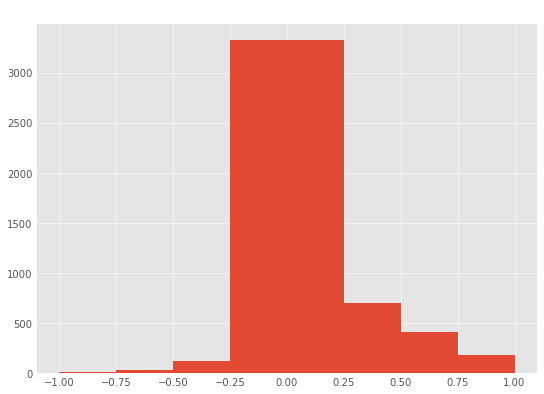

In [155]:
# Plot histogram of polarity values:

fig, ax = plt.subplots(figsize=(8,6))
tweets_en['Polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1], 
                          ax=ax)
plt.title("Sentiments (polarity) of English tweets")
plt.show()

# why doesnt the title show up?

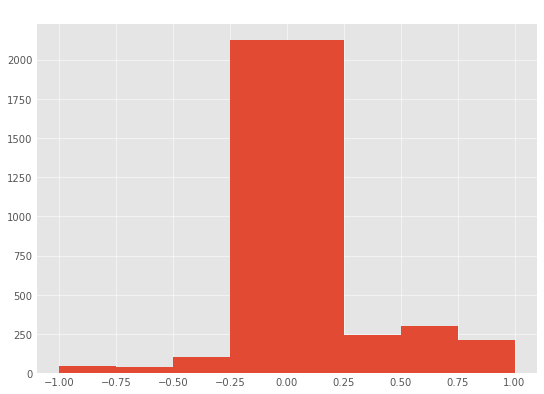

In [156]:
fig, ax = plt.subplots(figsize=(8,6))

tweets_de['Polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1], 
                          ax=ax)
plt.title("Sentiments (polarity) of German tweets")
plt.show()

# why doesnt the title show up?

### Add polarity column to df of all tweets and plot polarity by location rather than language.

#### Using Python package textblob to calculate SENTIMENT (pos/neg) values of individual tweets:

In [158]:
# sentiment_objects_en = [TextBlob(tweet) for tweet in tweets_en['TweetText']]

# sentiment_objects_en[0].sentiment, sentiment_objects[0]

### Try using Vader Sentiment instead of TextBlob:
* https://pypi.org/project/vaderSentiment/
* VADER (Valence Aware Dictionary and Sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.

In [170]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [171]:
def sentiment_scores_en(tweet):
    """Function to return the sentiment score of each tweet."""
    # create SentimentIntensityAnalyzer object
    obj = SentimentIntensityAnalyzer()
    
    # polarity_scores method. Object gives a sentiment dictionary
    # which contains pos, neg, neut, and compound scores.
    sentiment_dict = obj.polarity_scores(tweet)
    
    print("Overall sentiment dictionary is : ", sentiment_dict) 
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
    print("Sentence Overall Rated As", end = " ") 
    
    # decide sentiment as positive, negative, or neutral
    if sentiment_dict['compound'] >= 0.05:
        print("Positive")
    elif sentiment_dict['compound'] <= -0.05:
        print("Negative")
    else: 
        print("Neutral")

In [174]:
sentiment_scores_en("RT @rachel_groves: Daily goals: Wake up early. Drink coffee. Work hard. Be ambitious. Do what you love. Love what you do. Have fun. #inspir…")

Overall sentiment dictionary is :  {'neg': 0.04, 'neu': 0.54, 'pos': 0.42, 'compound': 0.9371}
sentence was rated as  4.0 % Negative
sentence was rated as  54.0 % Neutral
sentence was rated as  42.0 % Positive
Sentence Overall Rated As Positive


# START HERE:
apply this to the whole df and add new column for sentiment score!